Calculate the Wasserstein Barycenter and compares with the model average. 

Plan: 
    1. Different means as priors, and how that changes
    2. Different hyperparameter priors (changing frequencies etc), and how that changes

In [1]:
import gpflow
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
# matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib

# Set text size
matplotlib.rcParams['font.size'] = 18

# Seaborn for pairplots
import seaborn as sns

sns.set_context('talk', font_scale=1.2);
from sklearn import preprocessing

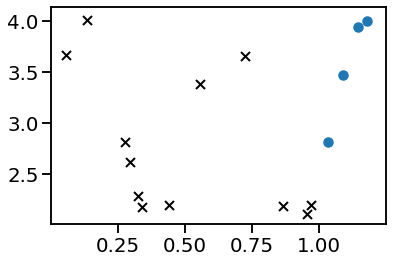

In [2]:
# Generate sample data from known GP
N = 12
N_predict = 4
predict_distance = 0.2
X = np.random.rand(N,1)
X_predict = 1.0 + np.random.rand(N_predict,1)*predict_distance
X_full = np.vstack((X, X_predict))
# Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.01 + 3
Y = np.sin(12*X) + np.random.randn(N,1)*0.01 + 3
Y_predict = np.sin(12*X_predict) + np.random.randn(N_predict,1)*0.01 + 3
plt.plot(X, Y, 'kx', mew=2)
plt.scatter(X_predict, Y_predict)

In [12]:
# GP 1 with a specific mean function prior

k1 = gpflow.kernels.SquaredExponential(lengthscale=0.1) * gpflow.kernels.Periodic(period = 12.0, lengthscales=0.2)
ktotal = k1
meanf1 = gpflow.mean_functions.Linear(10,1)
m1 = gpflow.models.GPR(X, Y, ktotal, meanf1)
m1.likelihood.variance = 0.01


ValueError: Attempt to convert a value (<gpflow.mean_functions.Linear object at 0x149d06860>) with an unsupported type (<class 'gpflow.mean_functions.Linear'>) to a Tensor.

In [ ]:
def plot(m, xx):
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
#     plt.xlim(-0.1, 1.1)

xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
plot(m1, xx)
plt.scatter(X_predict, Y_predict)

In [ ]:
# GP model 2

k2 = gpflow.kernels.RBF(lengthscales=0.1, input_dim = 1) * gpflow.kernels.Periodic(period = 12.0, lengthscales=0.2, input_dim = 1)
ktotal2 = k2
meanf2 = gpflow.mean_functions.Linear(-10,1)
m2 = gpflow.models.GPR(X, Y, ktotal2, meanf2)
m2.likelihood.variance = 0.01

In [ ]:

def plot(m, xx):
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
#     plt.xlim(-0.1, 1.1)

xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
plot(m2, xx)
plt.scatter(X_predict, Y_predict)

# Now, find the model average, compute $\int{p(f^*|M)p(M)dM}$ using monte carlo

In [ ]:
N_samp = 80
samps1 = m1.predict_f_samples(xx, N_samp).reshape(N_samp, len(xx))
samps2 = m2.predict_f_samples(xx, N_samp).reshape(N_samp, len(xx))


In [ ]:
notavg = (samps1 + samps2)/2

plt.plot(xx, notavg.T, c='g')
plt.scatter(X_predict, Y_predict)

plt.plot(xx, samps1.T);
plt.plot(xx, samps2.T);

In [ ]:
m1.kern.compute_K(xx, xx)
m2.kern.compute_K(xx, xx)

# Now just have to calculate GP barycenter and sample/plot this new gp! (copy the julia code)

In [ ]:
newxx = np.linspace(-0.1, 1.1, 50).reshape(50, 1)
me1, k1 = m1.predict_f_full_cov(xx)
k1 = k1.reshape(100, 100)
me2, k2 = m2.predict_f_full_cov(xx)
k2 = k2.reshape(100, 100)
kerns = [k1, k2]
# means = 
mean1, var = m1.predict_y(xx)
mean2, var = m2.predict_y(xx)
means = [mean1, mean2]

In [ ]:
def barycenter(means, kerns, N = 100):

    x = np.linspace(0., 1., N)

    xi = 1/len(kerns)

    # Calculate the barycenter mean
    # mm = lambda dist: np.mean(dist, x)
    mbar = sum([xi*meen for meen in means])

    # Calculate the barycenter covariance matrix`
    Kbar = np.random.rand(N, N)
    update = lambda kern, Kbar2, xi: xi * np.sqrt(Kbar2 * kern * Kbar2)

    T = 10000
    for t in range(1, T):
        Kbar2 = np.sqrt(Kbar)
        Kbar = np.sum([update(kern, Kbar2, xi) for kern in kerns], axis = 0)
    
    return mbar, Kbar

In [ ]:
mbar, Kbar = barycenter(means, kerns, N = 100)

In [ ]:
def plot(m, K):
    var = np.diag(K).reshape(100, 1)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, m, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     m[:,0] - 2*np.sqrt(var[:,0]),
                     m[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

In [ ]:
plot(mbar, Kbar)
N_samp = 1000
samps1 = m1.predict_f_samples(xx, N_samp).reshape(N_samp, len(xx))
samps2 = m2.predict_f_samples(xx, N_samp).reshape(N_samp, len(xx))
notavg = (samps1 + samps2)/2

plt.plot(xx, notavg.T, c='g', alpha = 0.1)
plt.scatter(X_predict, Y_predict)

plt.plot(xx, samps1.T, c = 'y', alpha = 0.01);
plt.plot(xx, samps2.T, c = 'r', alpha = 0.01);
plt.ylim(-1.0, 5.5)

In [ ]:
Kbar - k1

# Now try it with kernels that have different parameters etc

In [ ]:
def plot(m, xx):
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
#     plt.xlim(-0.1, 1.1)
k3 = gpflow.kernels.Matern12(lengthscales=0.1, input_dim = 1) + gpflow.kernels.Periodic(period = 12.0, lengthscales=0.2, input_dim = 1)
ktotal3 = k3
meanf3 = gpflow.mean_functions.Linear(-10,1)
m3 = gpflow.models.GPR(X, Y, ktotal3, meanf3)
m3.likelihood.variance = 0.01
xx = np.linspace(-0.1, 1.1, 100).reshape(xx.shape[0], 1)
plot(m3, xx)
plt.scatter(X_predict, Y_predict)

Now try to get the barycenter of this model (model 3, which has a very different covariance matrix) and model 1. Now, both the mean and the covariance matrix are different. 

Model average:

In [ ]:
N_samp = 80
samps1 = m1.predict_f_samples(xx, N_samp).reshape(N_samp, len(xx))
samps3 = m3.predict_f_samples(xx, N_samp).reshape(N_samp, len(xx))

notavg = (samps1 + samps3)/2

plt.plot(xx, notavg.T, c='g')
plt.scatter(X_predict, Y_predict)

plt.plot(xx, samps1.T);
plt.plot(xx, samps3.T);

In [ ]:
newxx = np.linspace(-0.1, 1.1, 50).reshape(50, 1)
me1, k1 = m1.predict_f_full_cov(xx)
k1 = k1.reshape(100, 100)
me3, k3 = m3.predict_f_full_cov(xx)
k3 = k3.reshape(100, 100)
kerns = [k1, k3]
# means = 
mean1, var = m1.predict_y(xx)
mean3, var = m3.predict_y(xx)
means = [mean1, mean3]

In [ ]:
# Compute the barycenter
mbar, Kbar = barycenter(means, kerns, N = 100)

In [ ]:
def plot(m, K):
    var = np.diag(K).reshape(100, 1)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, m, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     m[:,0] - 2*np.sqrt(var[:,0]),
                     m[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

In [ ]:
plot(mbar, Kbar)
N_samp = 1000
samps1 = m1.predict_f_samples(xx, N_samp).reshape(N_samp, len(xx))
samps3 = m3.predict_f_samples(xx, N_samp).reshape(N_samp, len(xx))
notavg = (samps1 + samps3)/2

plt.plot(xx, notavg.T, c='g', alpha = 0.1)
plt.scatter(X_predict, Y_predict)

plt.plot(xx, samps1.T, c = 'y', alpha = 0.006);
plt.plot(xx, samps3.T, c = 'r', alpha = 0.006);
plt.ylim(-1.0, 5.5)

# The barycenter seems to be the same as the model average, again! 

This could be due to the fact that they are unimodal? Maybe gaussians are a degenerate case where the barycenter IS the model average. Could try to do with more than one model (try all 3?). 

# Barycenter all 3 models

In [ ]:
N_samp = 80
notavg = (samps1 + samps2 + samps3)/3

plt.plot(xx, notavg.T, c='g')
plt.scatter(X_predict, Y_predict)

plt.plot(xx, samps1.T);
plt.plot(xx, samps2.T);
plt.plot(xx, samps3.T);

In [ ]:
means = [mean1, mean2, mean3]
kerns = [k1, k2, k3]

In [ ]:
def barycenter(means, kerns, N = 100, T=10000):

    x = np.linspace(0., 1., N)

    xi = 1/len(kerns)

    # Calculate the barycenter mean
    # mm = lambda dist: np.mean(dist, x)
    mbar = sum([xi*meen for meen in means])

    # Calculate the barycenter covariance matrix`
    Kbar = np.random.rand(N, N)
    update = lambda kern, Kbar2, xi: xi * np.sqrt(Kbar2 * kern * Kbar2)

    for t in range(1, T):
        Kbar2 = np.sqrt(Kbar)
        Kbar = np.sum([update(kern, Kbar2, xi) for kern in kerns], axis = 0)
    
    return mbar, Kbar
# Compute the barycenter
mbar, Kbar = barycenter(means, kerns, N = 100, T = 40)

In [ ]:
def plot(m, K):
    var = np.diag(K).reshape(100, 1)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, m, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     m[:,0] - 2*np.sqrt(var[:,0]),
                     m[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

In [ ]:
plot(mbar, Kbar)
N_samp = 1000
samps1 = m1.predict_f_samples(xx, N_samp).reshape(N_samp, len(xx))
samps2 = m2.predict_f_samples(xx, N_samp).reshape(N_samp, len(xx))
samps3 = m3.predict_f_samples(xx, N_samp).reshape(N_samp, len(xx))
notavg = (samps1 + samps2 + samps3)/3

plt.plot(xx, notavg.T, c='g', alpha = 0.1)
plt.scatter(X_predict, Y_predict)

plt.plot(xx, samps1.T, c = 'y', alpha = 0.006);
plt.plot(xx, samps2.T, c = 'r', alpha = 0.006);
plt.plot(xx, samps3.T, c = 'b', alpha = 0.003);
plt.ylim(-1.0, 5.5)

In [ ]:
realcov = 1/3 * kerns[0] + 1/3 * kerns[1] + 1/2 * kerns[2]
# estimated_cov = np.cov(notavg.T)

In [ ]:
realcov - Kbar

In [ ]:
plt.matshow(Kbar - (k1 + k2 + k3)/3)

In [ ]:
mbar, Kbar = barycenter(means, kerns, N = 100, T = 80000)

In [ ]:

plt.matshow(Kbar - (k1 + k2 + k3)/3)

# Try with two vastly different kernels, EQ() vs MA + Periodic(EQ()).:

In [ ]:
# GP 1 with a specific mean function prior

k1 = gpflow.kernels.RBF(lengthscales=0.1, input_dim = 1)
ktotal = k1
meanf1 = gpflow.mean_functions.Linear(10,1)
m1 = gpflow.models.GPR(X, Y, ktotal, meanf1)
m1.likelihood.variance = 0.01

def plot(m, K):
    var = np.diag(K).reshape(100, 1)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, m, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     m[:,0] - 2*np.sqrt(var[:,0]),
                     m[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
#     plt.xlim(-0.1, 1.1)
k3 = gpflow.kernels.Periodic(period = 12.0, lengthscales=0.2, input_dim = 1)
ktotal3 = k3
meanf3 = gpflow.mean_functions.Linear(-10,1)
m3 = gpflow.models.GPR(X, Y, ktotal3, meanf3)
m3.likelihood.variance = 0.01
xx = np.linspace(-0.1, 1.1, 100).reshape(xx.shape[0], 1)

newxx = np.linspace(-0.1, 1.1, 50).reshape(50, 1)
me1, k1 = m1.predict_f_full_cov(xx)
k1 = k1.reshape(100, 100)
me3, k3 = m3.predict_f_full_cov(xx)
k3 = k3.reshape(100, 100)
kerns = [k1, k3]

mean1, var = m1.predict_y(xx)
mean3, var = m3.predict_y(xx)
means = [mean1, mean3]

# Calculate the Barycenter
mbar, Kbar = barycenter(means, kerns, N = 100, T = 400)


In [ ]:
plot(mbar, Kbar)
N_samp = 1000
samps1 = m1.predict_f_samples(xx, N_samp).reshape(N_samp, len(xx))
samps3 = m3.predict_f_samples(xx, N_samp).reshape(N_samp, len(xx))
notavg = (samps1 + samps3)/2

plt.plot(xx, notavg.T, c='g', alpha = 0.1)
plt.scatter(X_predict, Y_predict)

plt.plot(xx, samps1.T, c = 'y', alpha = 0.006);
plt.plot(xx, samps3.T, c = 'b', alpha = 0.003);
plt.ylim(-1.0, 5.5)

In [ ]:
Kbar - (1/2*k1 + 1/2*k3)